# **Метрики оценки качества моделей и анализ ошибок в ML**

Одним из критически важных шагов при создании хорошей модели является правильный выбор метрики для оценки её качества, поскольку неправильный выбор может привести к неверным выводам и, как следствие, к принятию не самых оптимальных решений. Поэтому на сегодняшний день существует большое количество метрик, подходящих для самых разных задач и ситуаций.

В данном туториале будут рассмотрены популярные метрики для задач классификации, регрессии и кластеризации, а также инструмент для анализа ошибки модели, известный как bias-variance decomposition. Помимо этого, для большей части метрик будут представлены ручные расчёты и реализация с нуля на Python, а в конце вы сможете найти дополнительные источники для более глубокого ознакомления.

## **Метрики классификации**

Для простоты понимания рассмотрим бинарный случай. Однако, перед этим стоит тщательно ознакомиться с матрицей ошибок (confusion matrix) и её компонентами, представленными на изображении ниже.

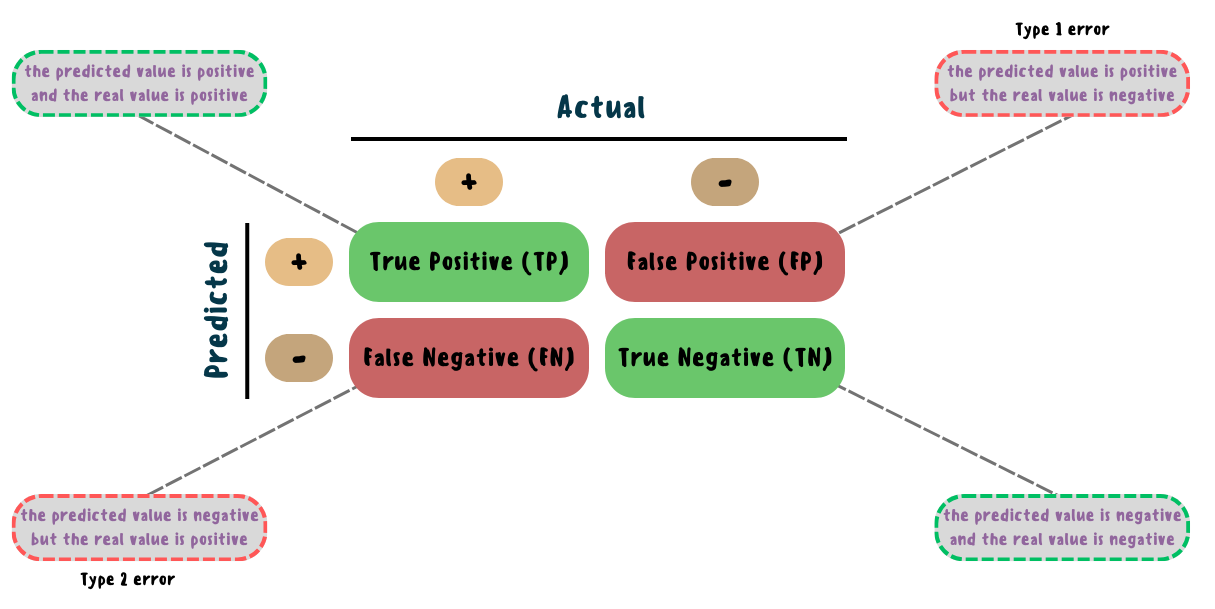

На главной диагонали расположены правильно классифицированные положительные (TP) и отрицательные (TN) классы, а на побочной — неправильно классифицированные, которые ещё называются ошибками первого (FP) и второго (FN) рода. Теперь обучим логистическую регрессию на датасете [Breast Cancer Wisconsin](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) и построим на основе её прогнозов данную матрицу. Однако, перед этим стоит упомянуть, что в scikit-learn порядок компонентов матрицы ошибок немного отличается от изображения выше, но это не меняет сути происходящего:

$$| TN \ \ FP | \\ | FN  \ \ TP |$$  

**Импорт необходимых библиотек**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, roc_curve, roc_auc_score, precision_recall_curve,
                             auc, average_precision_score, classification_report)

**Загрузка датасета**

In [2]:
df_path = "/content/drive/MyDrive/breast_cancer.csv"
breast_cancer = pd.read_csv(df_path)
breast_cancer.drop(columns=['id','Unnamed: 32'], inplace=True)
print(breast_cancer)

X = breast_cancer.drop(columns='diagnosis', axis=1)
y = breast_cancer['diagnosis']
y = LabelEncoder().fit_transform(y)

# 1 - Malignant, 0 - Benign
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0           M        17.99         10.38          122.80     1001.0   
1           M        20.57         17.77          132.90     1326.0   
2           M        19.69         21.25          130.00     1203.0   
3           M        11.42         20.38           77.58      386.1   
4           M        20.29         14.34          135.10     1297.0   
..        ...          ...           ...             ...        ...   
564         M        21.56         22.39          142.00     1479.0   
565         M        20.13         28.25          131.20     1261.0   
566         M        16.60         28.08          108.30      858.1   
567         M        20.60         29.33          140.10     1265.0   
568         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0            0.11840           0.27760         0.30010              

**Обучение и прогноз модели логистической регрессии**

In [3]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0
 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1]


**Построение и визуализация confusion matrix**

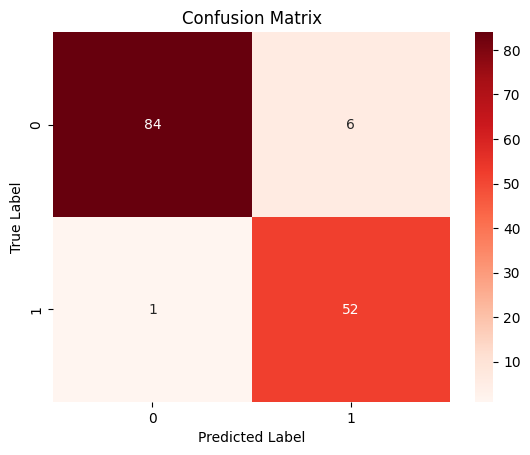

In [4]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Глядя на полученную матрицу ошибок, мы имеем следующее:
- (True Positive) — 52 человека классифицированы как больные и они такими являются, то есть классифицированы верно;
- (True Negative) — 84 человека классифицированы как здоровые и они такими являются, то есть также классифицированы верно;
- (False Positive) — 6 человек классифицированы как больные (то есть имеют злокачественную опухоль), но они здоровые (то есть опухоль доброкачественная);
- (False Negative) — 1 человек определён как здоровый, но он болен (то есть имеет злокачественную опухоль).

Теперь можно переходить к самим метрикам.



### **Accuracy**

Самым простым способом оценить качество модели является **Accuracy** или точность, которая отражает долю правильно спрогнозированных классов среди всех образцов:

$$\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} I [y_i = \hat y_i] = \frac{TP + TN}{TP + TN + FP + FN}$$

Теперь получим значение Accuracy для нашего примера:

$$\frac{52 + 84}{52 + 84 + 6 + 1} = 0.951048951048951$$

Отсюда также можно определить долю ошибочных классификаций **Error rate**, которая показывает напрямую, как часто модель совершает ошибки:

$$1 - \text{Accuracy} = 1 - 0.951048951048951 = 0.04895104895104896$$






In [5]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
print(f'Accuracy: {accuracy}')
print(f'Error rate: {error_rate}')

Accuracy: 0.951048951048951
Error rate: 0.04895104895104896


Не смотря на свою простоту и универсальность, Accuracy имеет ряд серьёзных недостатков:
- не учитывает дисбаланс классов: если один класс значительно преобладает над другим, то модель может быть смещена в его сторону, и тогда высокая точность не будет отражать истинное качество модели;
- не даёт информацию о типе ошибок модели, например, о количестве ложноположительных и ложноотрицательных результатов, что не позволяет учитывать цену ошибки для разных классов;
- зависит от порога классификации, изменение которого может значительно повлиять на значение точности.

Далее будут рассмотрены метрики, в которых устраняются данные недостатки.

### **Precision**

Характеризует долю правильно предсказанных положительных классов среди всех образцов, которые модель спрогнозировала как положительный класс:

$$\text{Precision} = TPR = \frac{TP}{TP + FP} = \frac{52}{52 + 6} = 0.896551724137931$$

In [6]:
precision = precision_score(y_test, y_pred)
print(precision)

0.896551724137931


Чем меньше ложноположительных прогнозов, тем выше Precision модели. В данном случае эта метрика также важна, поскольку позволяет пациентам избежать дополнительного стресса и ненужного лечения в случае ложноположительного диагноза.

### **Recall (TPR)**

Ещё известное как True Positive Rate, отражает долю правильно предсказанных положительных классов среди всех реальных положительных образцов:

$$\text{Recall} = \frac{TP}{TP + FN} = \frac{52}{52 + 1} = 0.9811320754716981$$

In [7]:
recall = recall_score(y_test, y_pred)
print(recall)

0.9811320754716981


Чем меньше ложноотрицательных прогнозов, тем выше Recall или TPR. В контексте рака груди, данные метрики являются ещё более важными, чем предыдущая, поскольку показывают какое число злокачественных опухолей удалось действительно выявить.

### **FPR**

False Positive Rate характеризует долю ошибочно предсказанных положительных классов среди всех образцов, которые на самом деле являются отрицательным классом. Другими словами, это показывает, как часто модель неверно прогнозирует наличие заболевания (в случае рака груди), когда его на самом деле нет (доброкачественные образцы, ошибочно идентифицированные как раковые от всех реальных доброкачественных случаев).

Для лучшего понимания только что описанных метрик стоит ознакомиться с изображением ниже.

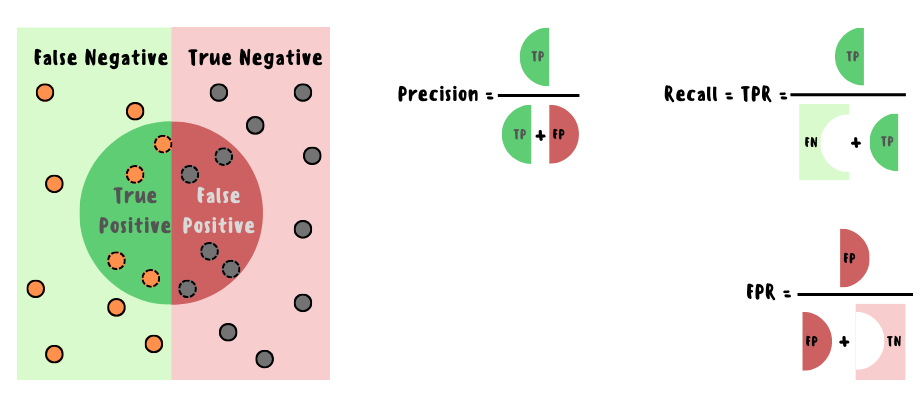

### **F1-score**

Представляет собой гармоническое среднее между Precision и Recall, обеспечивая между ними баланс, что особенно полезно при неравномерном распределении классов. Использование данной метрики позволяет лучше выбрать модель, которая не только точно классифицирует злокачественные случаи, но и минимизирует количество пропущенных злокачественных опухолей.

$$\text{F1-score} = 2 \cdot \frac{precision \cdot recall}{precision + recall} \approx 2 \frac{0.8966 \cdot 0.9811}{0.8966 + 0.9811} \approx 0.936948671246738$$

In [8]:
f1 = f1_score(y_test, y_pred)
print(f1)

0.9369369369369369


Стоит добавить, что F1-score исходит из предположения, что Precision и Recall имеют одинаковую важность. Если же необходимо придать большее значение (вес) одной из метрик, то можно воспользоваться **$F_{\beta}$ - score**:

$$\text{F}_{\beta}= (1 + \beta^2) \cdot \frac{precision \cdot recall}{\beta^2 \cdot precision + recall}$$

При $\beta > 1$ большее значение придаётся Recall, а при $\beta < 1$ — Precision. Другими словами, если мы хотим сфокусироваться больше на действительно обнаруженных опухолях, то мы увеличиваем $\beta$, если же мы хотим избежать ложноположительных прогнозов (то есть когда у человека нет рака, а модель прогнозирует, что есть), то мы уменьшаем $\beta$. Например, при $\beta = 2$ получим следующее:

$$F_2 \approx (1 + 2^2) \cdot \frac{0.8966 \cdot 0.9811}{2^2 \cdot 0.8966 + 0.9811} \approx 0.9629493814997262$$

In [9]:
f2 = fbeta_score(y_test, y_pred, beta=2)
print(f2)

0.9629629629629629


### **ROC-AUC**

Все предыдущие метрики позволяют оценить качество модели только при определённом пороге классификации. В случае, когда необходимо оценить качество модели при различных пороговых значениях, используется AUC-площадь (Area Under Curve) под ROC-кривой (Receiver Operating Characteristics curve), выраженной через отношение доли истинно положительных прогнозов (TPR) к доли ложноположительных (FPR).



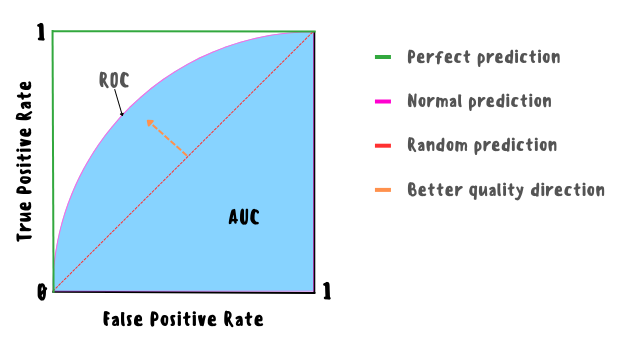

В идеальном случае ROC-кривая будет стремиться в верхний левый угол (TPR=1 и FPR=0), а площадь под ней (AUC) будет равна единице. При значении площади 0.5 качество прогнозов модели будет сопоставимо случайному угадыванию, ну а если это значение меньше 0.5, то, модель лучше предсказывает результаты, противоположные истинным — в таком случае нужно просто поменять целевые метки местами для получения площади больше 0.5.

Для лучшего понимания построим данную метрику с нуля. В общем виде процесс состоит из следующих шагов:

- 1) сначала предсказанные моделью вероятности быть положительным классом сортируются в порядке убывания и принимаются как пороговые значения;
- 2) для каждого порога выполняется классификация (бинаризация) меток на 1 и 0, а на их основе рассчитываются FPR и TPR;
- 3) полученные FPR и TPR используются для расчёта AUC с помощью метода трапеций, который выглядит следующим образом:

$$AUC = \sum_{i=1}^{n-1} \frac{TPR_i + TPR_{i+1}}{2} (FPR_{i+1} - FPR_i)$$

Однако такой процесс является неэффективным, поскольку при построении ROC-кривой используются все пороги, большинство из которых неоптимальные. Что это означает? При построении графика между двумя точками проводится прямая и если между ними есть ещё одна точка, расположенная на том же уровне, то она не будет отображаться на построенной ROC-кривой. Именно подобного рода точки называются неоптимальными. Следовательно, для построения ROC-кривой и расчёта площади под ней достаточно знать лишь угловые точки, что помимо прочего позволит строить более лёгкие ROC-кривые. Для поиска оптимальных значений необходимо выполнить следующие шаги:

- 1) для каждого отсортированного в порядке убывания порога выполняется бинаризация меток, на основе которых рассчитываются FP и TP;
- 2) для полученных FP и TP рассчитывается вторая разница между соседними значениями, которая выступает в качестве второй производной;
- 3) в местах, где вторая производная не равна нулю, будут расположены угловые точки;
- 4) позиции в списке угловых точек используются для поиска оптимальных порогов, FP и TP;
- 5) к списку оптимальных FP и TP добавляются нули в начало, чтобы ROC-кривая всегда начиналась в точке (0, 0); а к списку оптимальных порогов в начало добавляется максимальное значение y_score + 1, чтобы ROC-кривая заканчивалась в единице даже если все образцы неверно классифицированы;
- 6) на основе полученных оптимальных значений FP и TP рассчитываются оптимальные FPR и TPR, которые в дальнейшем используются для расчёта AUC с помощью метода трапеций.

**Реализация с нуля**

AUC: 0.9951781970649896

Optimal False Positive Rates:
[0.         0.         0.         0.01111111 0.01111111 0.04444444
 0.04444444 0.12222222 0.12222222 1.        ]

Optimal True Positive Rates:
[0.         0.01886792 0.86792453 0.86792453 0.94339623 0.94339623
 0.98113208 0.98113208 1.         1.        ]

Optimal thresholds:
[2.00000000e+00 1.00000000e+00 9.39251068e-01 9.28758892e-01
 8.62519599e-01 7.34708679e-01 6.73824037e-01 2.39038287e-01
 2.23663185e-01 1.80054591e-06]


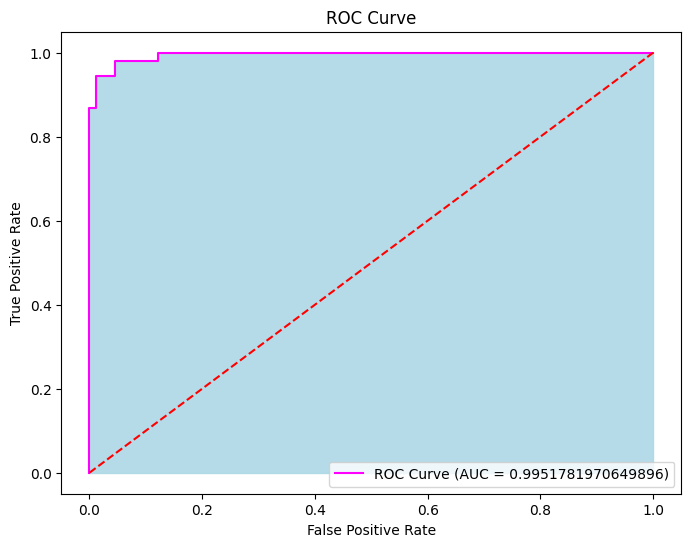

In [10]:
def binary_roc_curve(y_true, y_score):
    thresholds = np.sort(y_score)[::-1]
    tps = np.array([])   # True positives
    fps = np.array([])   # False positives

    for threshold in thresholds:
        # predictions binarization by each threshold
        y_pred = (y_score >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        tps = np.append(tps, tp)
        fps = np.append(fps, fp)

    # find optimal (corner) points (thresholds)
    corner_point = True
    d2_fps = np.diff(fps, 2)   # is used as a "second derivative"
    d2_tps = np.diff(tps, 2)
    is_corner_points = np.r_[corner_point, np.logical_or(d2_fps, d2_tps), corner_point]
    optimal_indexes = np.where(is_corner_points == corner_point)[0]

    # add an extra threshold position to optimal values to make sure that the curve starts
    # at (0, 0) and also ends in 1 even if all samples are incorrectly classified
    optimal_fps = np.r_[0, fps[optimal_indexes]]
    optimal_tps = np.r_[0, tps[optimal_indexes]]
    optimal_thresholds = np.r_[max(y_score) + 1, thresholds[optimal_indexes]]

    optimal_fpr = optimal_fps / optimal_fps[-1]
    optimal_tpr = optimal_tps / optimal_tps[-1]

    return optimal_fpr, optimal_tpr, optimal_thresholds


def area_by_trapz(y, x):
    dx = np.diff(x)   # height

    return 0.5 * ((y[1:] + y[:-1]) * dx).sum()


def binary_roc_auc_score(y_test, y_pred):
    fpr, tpr, _ = binary_roc_curve(y_test, y_pred)

    return area_by_trapz(tpr, fpr)


y_pred_probas = model.predict_proba(X_test)[:, 1]
roc_auc = binary_roc_auc_score(y_test, y_pred_probas)
fpr, tpr, thresholds = binary_roc_curve(y_test, y_pred_probas)

print(f'AUC: {roc_auc}', '', sep='\n')
print('Optimal False Positive Rates:', fpr, '', sep='\n')
print('Optimal True Positive Rates:', tpr, '', sep='\n')
print('Optimal thresholds:', thresholds, sep='\n')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc})', color='fuchsia')
plt.plot([0, 1], [0, 1], 'r--')  # Dashed diagonal line
plt.fill_between(fpr, tpr, color='lightblue', alpha=0.9)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Реализация scikit-learn**

In [11]:
sk_roc_auc = roc_auc_score(y_test, y_pred_probas)
sk_fpr, sk_tpr, sk_thresholds = roc_curve(y_test, y_pred_probas)

print(f'AUC (scikit-learn): {sk_roc_auc}', '', sep='\n')
print('Optimal False Positive Rates (scikit-learn):', sk_fpr, '', sep='\n')
print('Optimal True Positive Rates (scikit-learn):', sk_tpr, '', sep='\n')
print('Optimal thresholds (scikit-learn):', sk_thresholds, sep='\n')

AUC (scikit-learn): 0.9951781970649896

Optimal False Positive Rates (scikit-learn):
[0.         0.         0.         0.01111111 0.01111111 0.04444444
 0.04444444 0.12222222 0.12222222 1.        ]

Optimal True Positive Rates (scikit-learn):
[0.         0.01886792 0.86792453 0.86792453 0.94339623 0.94339623
 0.98113208 0.98113208 1.         1.        ]

Optimal thresholds (scikit-learn):
[2.00000000e+00 1.00000000e+00 9.39251068e-01 9.28758892e-01
 8.62519599e-01 7.34708679e-01 6.73824037e-01 2.39038287e-01
 2.23663185e-01 1.80054591e-06]


ROC-AUC имеет смысл использовать в задачах, где важны не столько предсказанные классы, сколько их правильный вероятностный порядок. Например, у нас есть онлайн-кинотеатр и мы хотим узнать какие пользователи будут продлевать месячную подписку. На первый взгляд может показаться, что эта обычная бинарная классификация и нужно просто предсказать метки, однако более полезным вариантом будет упорядочивание клиентов по вероятности отмены подписки, чтобы в дальнейшем использовать различные стратегии для их удержания.

Отсюда может сложиться впечатление, что ROC-AUC является хорошей метрикой для задач ранжирования, однако не всё так просто, как может показаться на первый взгляд. Дело в том, что ROC-AUC не очень хорошо справляется с сильным дисбалансом классов, поскольку учитывает истинно отрицательные случаи (TN), что вытекает из расчётов FPR. Проще говоря, модель может показать высокий TPR, но при этом также иметь большое количество ложноположительных предсказаний (FPR).

### **PR-AUC и Average Precision (AP)**

В таком случае можно использовать площадь в осях Precision Recall, известную как **PR-AUC**, которая лучше подходит для данных с сильным дисбалансом классов. Это связано с тем, что PR-AUC фокусируется на соотношении истинно положительных и ложноотрицательных результатов, что отражает лучше способность модели правильно определять положительные классы и, следовательно, лучше справляться в задачах ранжирования, где это необходимо в первую очередь. Например, если мы хотим показать пользователю наиболее релевантные фильмы, PR-AUC будет лучше учитывать действительно интересные для пользователя фильмы (TP), в то время как ROC-AUC может учесть наименее интересные фильмы (TN). Также стоит добавить, что в отличие от ROC-AUC, на графике PR-AUC будет стремиться в правый верхний угол, а её нахождение выполняется следующим образом:

In [12]:
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_probas)
pr_auc_score = auc(recalls, precisions)
print(pr_auc_score)

0.9924452566260418


Однако и здесь не всё так просто, поскольку расчёт PR-AUC также основан на методе трапеций, который, в свою очередь, использует линейную интерполяцию. Что в этом может быть плохого? Если интерполяцию между двумя точками в ROC-пространстве можно выполнить, просто соединив их прямой линией, то в PR-пространстве интерполяция может иметь более сложную связь. При изменении уровня Recall, метрика Precision не обязательно будет изменяться линейно, поскольку FP заменяет FN в знаменателе Precision. В таком случае линейная интерполяция является ошибочной и может давать слишком оптимистичную оценку качества модели. Проще говоря, в случае PR-AUC такой подход может считать завышенную площадь под кривой.

Поэтому в scikit-learn существует альтернативная (и очень схожая) метрика, которая называется **Average Precision**. Её основное отличие как раз и заключается в том, что для расчёта не используется линейная интерполяция. Вместо этого кривая Precision-Recall суммируется как средневзвешенное значение Precisions, полученное для каждого порога, а в качестве веса используется увеличение Recall по сравнению с предыдущим порогом:

$$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$$

In [13]:
ap_score = average_precision_score(y_test, y_pred_probas)
print(ap_score)

0.992511694643552


### **Когда классов больше двух**

Обычно задача классификации на $K$ классов сводится к отделению класса $k$ от всех остальных с последующим расчётом consufion matrix для каждого из них. В таком случае для получения итогового значения метрики можно применить усреднённые методы:

- 1) **Микро-усреднение (micro-averaging)** является эквивалентом accuracy и подходит при сбалансированных классах. Элементы consufion matrix усредняются между бинарными прогнозами для каждого класса, после чего метрики рассчитываются на полученной матрице. На примере Precision и Recall это выглядит следующим образом:

$$\text{Precision}_{\text{(micro)}} = \frac{\sum_{k=1}^{K} \text{TP}_k}{\sum_{k=1}^{K} (\text{TP}_k + \text{FP}_k)}$$

$$\text{Recall}_{\text{(micro)}} = \frac{\sum_{k=1}^{K} \text{TP}_k}{\sum_{k=1}^{K} (\text{TP}_k + \text{FN}_k)}$$

- 2) **Макро-усреднение (macro-averaging)** представляет собой среднее арифметическое подсчитанной метрики для каждого класса и используется при дисбалансе классов, когда важен каждый класс. В таком случае все классы учитываются равномерно независимо от их размера:

$$\text{Precision}_{\text{(macro)}} = \frac{1}{K} \sum_{k=1}^{K} \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}$$

$$\text{Recall}_{\text{(macro)}} = \frac{1}{K} \sum_{k=1}^{K} \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}$$

- 3) **Взвешенное усреднение (weighted averaging)** рассчитывается как взвешенное среднее и также применяется в случае дисбаланса классов, но только когда важность класса учитывается в зависимости от количества объектов с таким классом, то есть когда важны наибольшие классы. При таком подходе важность каждого класса учитывается с присвоением им весов. Вес класса **w_k** может устанавливаться по-разному, например, как доля примеров этого класса в обучающей выборке:

$$\text{Precision}_{\text{(weighted)}} = \sum_{k=1}^{K} w_k \cdot \frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}$$

$$\text{Recall}_{\text{(weighted)}} = \sum_{i=1}^{K} w_k \cdot \frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}$$

Для лучшего понимания рассмотрим пример с подсчётом наиболее популярных метрик на данных [Red Wine Quality](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/data). Для этого воспользуемся функцией classification_report из scikit-learn.


**Загрузка датасета**

In [14]:
red_wine = pd.read_csv("/content/drive/MyDrive/winequality-red.csv")
print(red_wine)

X = red_wine.drop(columns='quality', axis=1)
y = red_wine['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free sulfur dioxide  

**Обучение модели и оценка полученных результатов**

Первое, что можно заметить, что, в целом, классификатор справился не очень хорошо. Следующим интересным наблюдением является то, что из-за сильного дисбаланса классов не все классы были спрогнозированы, поэтому метрики для некоторых классов помечены нулями.

В данном случае микро-усреднение (accuracy) показало завышенные результаты, а вот макро показывает более реальную картину при условии, что все спрогнозированные классы имеют для нас одинаково значение. Взвешенное усреднение, в свою очередь, показало способность модели определять наиболее распространённые классы, которая также оказалась не очень хорошая.

In [15]:
ovr_model = LogisticRegression(multi_class='ovr', max_iter=1000)
ovr_model.fit(X_train, y_train)
y_pred = ovr_model.predict(X_test)

clf_report = classification_report(y_test, y_pred)
print(clf_report)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        14
           5       0.65      0.78      0.71       169
           6       0.59      0.63      0.61       170
           7       0.50      0.20      0.29        40
           8       0.00      0.00      0.00         5

    accuracy                           0.62       400
   macro avg       0.29      0.27      0.27       400
weighted avg       0.58      0.62      0.59       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Метрики регрессии**

В данном случае целевая метка представляет собой вещественное число, поскольку это связано с природой регрессионных задач, например, прогноз погоды, стоимость акций, цена на недвижимость и так далее. Поэтому большинство метрик в задачах регрессии представляют собой среднюю оценку разности между действительными и спрогнозированными значениями, однако, с некоторыми особенностями. Рассмотрим их более подробно, обучив линейную регрессию на данных [Medical Cost Personal](https://www.kaggle.com/datasets/mirichoi0218/insurance/data).




**Импорт необходимых библиотек**

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_error, mean_squared_log_error, r2_score)

**Загрузка датасета**

In [17]:
df_path = "/content/drive/MyDrive/insurance.csv"
insurance_cost = pd.read_csv(df_path)
print(insurance_cost)

X = insurance_cost.drop(columns='charges', axis=1)
y = insurance_cost['charges']

cat_features_list = X.select_dtypes(include=['object']).columns
X[cat_features_list] = X[cat_features_list].apply(LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1338 rows x 7 columns]


**Обучение линейной регрессии**

In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[10947.91401491  9764.82733066 38027.18625354 16076.26656375
  7003.05093861  4162.38974052  1745.17453352 14273.5330135
  9022.7490154   7548.70107263  4742.33662827 10290.75344147
  8592.56051588  4173.37165612 27970.0324915  11026.04778351
 11286.00941429  6197.06911697  8269.51468144 27263.01056172
 33686.9512703  14247.8812616  11735.79293452 32419.5578177
  4475.57228648  9264.65728706  1336.5408973  10083.42064465
  4134.01766875 10422.0367284   9033.04363126 40177.36502272
 15327.89185262 13541.84076855 24979.41529438  5273.0794857
 12809.44891047 30538.99654744 33503.98483751  3477.84775709
  4169.03343497  4346.93367013 30642.90398321 39366.95813634
 28066.36347631  5110.98142166 10919.49675465  7870.63024919
  3790.77872548 10529.86942143  5758.50260778  3526.36470247
 32837.53966438 38431.60954739 16119.53210068  7198.88399648
  6010.47765564  9455.45703492  9323.82247057 11736.15685931
  1745.70435635 38856.13381995 15133.33969997 11575.03834933
 14071.5724629  13696.52725

### **MAE**

**Mean Absolute Error** показывает насколько в среднем прогнозы модели отклоняются от реальных значений по модулю:

$$\text{MAE}(y, \hat y) = \frac{1}{N} \sum_{i=1}^N |y_i - \hat y_i|$$

Данная метрика проста в интерпретации и устойчива к выбросам, однако не учитывает масштаб (насколько велико полученное отклонение) и направление ошибок (положительное или отрицательное отклонение от реальных значений).

In [19]:
def mae_score(y_true, y_pred):
    n = len(y_true)

    return 1 / n * np.sum(np.abs(y_true - y_pred))


mae = mae_score(y_test, y_pred)
sk_mae = mean_absolute_error(y_test, y_pred)
print(f'mae: {mae}')
print(f'mae(scikit-learn): {sk_mae}')

mae: 3998.2715408869726
mae(scikit-learn): 3998.2715408869726


Как можно заметить, полученная ошибка не может нам показать напрямую как сильно ошибается модель. Другими словами, в зависимости от контекста точно такое же значение MAE может быть как хорошим, так и плохим результатом. Представим следующую ситуацию: нам необходимо спрогнозировать на какую сумму сеть магазинов продаст бананы. Для этого смоделируем новые данные на основе предыдущих, добавив к ним значение 10000.

In [20]:
true_sales = y_test + 10_000
pred_sales = y_pred + 10_000

mae_for_sales = mean_absolute_error(true_sales, pred_sales)
print(f'mae(for sales): {mae_for_sales}')

mae(for sales): 3998.2715408869726


Нетрудно догадаться, что не смотря на одинаковые MAE, в одном случае качество модели будет лучше, чем в другом. В такой ситуации удобно рассматривать не абсолютную, а относительную ошибку на объектах.

### **MAPE & SMAPE**

**Mean Absolute Percentage Error** как раз позволяет оценить в процентах насколько прогнозы модели отличаются относительно реальных значений:

$$\text{MAPE}(y, \hat y) = \frac{1}{N} \sum_{i=1}^N \frac{|y_i - \hat y_i|}{|y_i|}$$

In [21]:
def mape_score(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true)

    return  1 / n * np.sum(numerator / denominator)


mape = mape_score(y_test, y_pred)
sk_mape = mean_absolute_percentage_error(y_test, y_pred)
mape_for_sales = mean_absolute_percentage_error(true_sales, pred_sales)

print(f'mape: {mape}')
print(f'mape(scikit-learn): {sk_mape}')
print(f'mape(for sales): {mape_for_sales}')

mape: 0.4138713715103651
mape(scikit-learn): 0.4138713715103651
mape(for sales): 0.15963240527305983


Теперь хорошо видно, что модель в первом случае ошибается гораздо сильнее, даже не смотря на одинаковые значения MAE. Однако MAPE не подходит для случаев, когда хотя бы одно фактическое значение равно нулю, что видно из формулы. В таком случае можно использовать симметричную MAPE, известную как **Symmetric Mean Absolute Percentage Error**:

$$\text{SMAPE}(y, \hat y) = \frac{1}{N} \sum_{i=1}^N \frac{2 |y_i - \hat y_i|}{y_i + \hat y_i}$$



In [22]:
def smape_score(y_true, y_pred):
    n = len(y_true)
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = (y_true + y_pred)

    return  1 / n * np.sum(numerator / denominator)


smape = smape_score(y_test, y_pred)
print(f'smape: {smape}')

smape: 0.3573799807309885


### **WAPE**

Как и другие метрики, MAPE также применима не во всех условиях. Например, она плохо справляется при анализе временных рядов с сезонными колебаниями, поскольку не учитывает относительную значимость наблюдений и плохо работает с неравномерными данными. Для такого случая лучше подходит **Weighted Average Percentage Error**, которая нормализует общую ошибку к общей сумме фактических значений:

$$\text{WAPE}(y, \hat y) = \frac{\sum_{i=1}^N |y_i - \hat y_i|}{\sum_{i=1}^N |y_i|}$$

Например, продажи мороженого имеют ярко выраженную сезонность, при этом продажи в летние месяцы значительно выше, чем в зимние. В таком случае WAPE покажет более реальную оценку, поскольку будет учитывать ошибку прогноза для каждого месяца относительно общего объёма продаж, что в итоге позволит лучше справляться с прерывистыми продажами.



In [23]:
def wape_score(y_true, y_pred):
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true))

    return numerator / denominator


wape = wape_score(y_test, y_pred)
print(f'wape: {wape}')

wape: 0.29762832405759587


### **MSE & RMSE**

**Mean Squared Error** показывает насколько в среднем прогнозы модели отклоняются от реальных значений в квадрате:

$$\text{MSE}(y, \hat y) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2$$

Данная метрика полезна в тех случаях, когда нужно сделать акцент на больших ошибках и выбрать модель, которая допускает их в среднем меньше всего. С другой стороны, из-за квадрата разности в формуле выше, MSE чувствительна к выбросам и более сложна для восприятия по сравнению с MAE.

In [24]:
def mse_score(y_true, y_pred):
    n = len(y_true)

    return 1 / n * np.sum((y_true - y_pred) ** 2)


mse = mse_score(y_test, y_pred)
sk_mse = mean_squared_error(y_test, y_pred)
print(f'mse: {mse}')
print(f'mse(scikit-learn): {sk_mse}')

mse: 32073628.560109198
mse(scikit-learn): 32073628.560109198


Поэтому, чтобы придать значению MSE размерность исходных данных, из него извлекается квадратный корень. Такая метрика называется **Root Mean Squared Error** и её основное преимущество заключается в лучшей интерпретируемости в сравнении с MSE:

$$\text{RMSE}(y, \hat y) = \sqrt{\frac{1}{N} \sum_{i=1}^N (y_i - \hat y_i)^2}$$


In [25]:
rmse = np.sqrt(mse)
print(f'rmse: {rmse}')

rmse: 5663.358417062193


### **MSLE & RMSLE**

Ещё одним способом перехода к относительным ошибкам является их измерение в логарифмическом масштабе, как это делается в **Mean Squared Logarithmic Error**:

$$\text{MSLE}(y, \hat y |c) = \frac{1}{N} \sum_{i=1}^N (\text{ln}(y_i + c) - \text{ln}(\hat y_i + c))^2$$

где $c$ - нормированная константа (обычно равна 1), которая вводится, чтобы избегать логарифма нуля.

Данная метрика более устойчива к выбросам, поскольку делает распределение целевых и спрогнозированных значений более однородным. С другой стороны, MSLE труднее интерпретировать, а также стоит иметь в виду, что она уделяет больше внимания заниженным прогнозам, поскольку логарифм является несимметричной функцией.

In [26]:
def msle_score(y_true, y_pred, c=1):
    n = len(y_true)

    return 1 / n * np.sum((np.log(y_true + c) - np.log(y_pred + c)) ** 2)


msle = msle_score(y_test, y_pred)
sk_msle = mean_squared_log_error(y_test, y_pred)
print(f'msle: {msle}')
print(f'msle(scikit-learn): {sk_msle}')

msle: 0.2966547825040618
msle(scikit-learn): 0.2966547825040618


Соответственно, чтобы оценить значение MSLE относительно размерности исходных данных, используется **Root Mean Squared Logarithmic Error**:

$$\text{RMSLE}(y, \hat y |c) = \sqrt{\frac{1}{N} \sum_{i=1}^N (\text{ln}(y_i + c) - \text{ln}(\hat y_i + c))^2}$$

In [27]:
rmsle = np.sqrt(msle)
print(f'rmsle {rmsle}')

rmsle 0.5446602450189125


### **R2 & Adjusted R2**

Иногда бывает трудно понять насколько хорошее или плохое значение рассчитанной ошибки, поэтому было бы удобно иметь в каком-то смысле аналог точности в процентах, но только для задачи регрессии. К счастью, такая метрика существует и это коэффициент детерминации $\text{R}^2$, который показывает какая доля дисперсии целевых значений объясняется моделью:

$\text{R}^2 = \frac{SST - SSR}{SST} = 1 - \frac{SSR}{SST} = 1 - \frac{\sum_{i=1}^N(y_i - \hat y_i)^2}{\sum_{i=1}^N(y_i - \overline y)^2}$

где $SSR$ — Sum of Squared Residuals, а $SST$ — Sum of Squares Total.

В отличии от предыдущих метрик, в данном случае более высокое значение метрики говорит о лучшем качестве модели. Значения $\text{R}^2$ можно интерпретировать следующим образом:

- 1) $\text{R}^2 = 1$ — модель идеально предсказывает данные;
- 2) $\text{R}^2 = 0$ — прогнозы модели соответствуют среднему арифметическому фактических целевых значений;
- 3) $\text{R}^2 < 0$ — модель работает хуже, чем простое использование среднего значения фактических целевых значений (обычно это связано с тем, что модель обучалась на данных, в которые попали большие выбросы).


In [28]:
def manual_r2_score(y_true, y_pred):
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - y_true.mean()) ** 2)

    return 1 - ssr / sst


r2 = manual_r2_score(y_test, y_pred)
sk_r2 = r2_score(y_test, y_pred)
print(f'r2: {r2}')
print(f'r2(scikit-learn): {sk_r2}')

r2: 0.7962732059725786
r2(scikit-learn): 0.7962732059725786


Стоит отметить, что $\text{R}^2$ также имеет свои ограничения. Его основная проблема заключается в том, что он не учитывает количество признаков в модели. Другими словами, $\text{R}^2$ имеет тенденцию к увеличению при добавлении в обучающий набор новых признаков, даже если они не улучшают качество модели.

В таком случае сравнение моделей с разным количеством признаков становится некорректным, поэтому специально для этой цели используется скорректированный **Adjusted $\text{R}^2$**, который использует введение штрафа за добавленные признаки:

$$\text{R}_{adj}^2 = 1 - \frac{SSR \cdot (n-1)}{SST \cdot (n - k - 1)} = 1 - \frac{(1 - R^2) (n - 1)}{n - k - 1}$$

где $n$ — число наблюдений, а $k$ — количество признаков.

In [29]:
def adjusted_r2_score(y_true, y_pred, x_shape):
    n, k = x_shape
    ssr = np.sum((y_true - y_pred) ** 2)
    sst = np.sum((y_true - y_true.mean()) ** 2)
    r2 = 1 - ssr / sst

    return 1 - (1 - r2) * (n - 1) / (n - k - 1)


r2_adj = adjusted_r2_score(y_test, y_pred, X.shape)
print(f'r2 adjusted: {r2_adj}')

r2 adjusted: 0.7953548282384204


## **Bias-Variance Decomposition**

Не отходя далеко от темы регрессии, рассмотрим разложение ошибки модели на смещение, разброс и случайный шум в данных. Это полезный инструмент, позволяющий оценить влияние вышеописанных компонентов общей тестовой ошибки и подобрать наиболее оптимальную модель с точки зрения её сложности.



### **Вывод разложения ошибки для MSE**

Для простоты рассмотрим задачу регрессии со среднеквадратичной функцией потерь. Предположим, что целевое значение $y$ можно выразить с помощью некоторой детерминированной функции $f$ следующим образом:

$$y = f(x) + \varepsilon$$

где $\varepsilon$ — случайный шум, причём $E [\varepsilon] = 0, \ E [\varepsilon^2] = \sigma^2$.

Тогда MSE для прогноза модели $\hat f(x)$ будет выглядеть следующим образом:

$$MSE = E[(y - \hat f(x))^2] = E[y^2] - 2E[y \hat f(x)] + E[\hat f(x)^2]$$

где смещение и разброс для $\hat f(x)$ равны соответственно:

$$Bias[\hat f(x)] = f(x) - E[\hat f(x)]$$
$$Var[\hat f(x)] = E[\hat f(x)^2] - E[\hat f(x)]^2$$

Теперь можно расписать каждый компонент по отдельности:

$$\begin{align*}
E[y^2] & = E[f(x)^2] + E[\varepsilon^2] + 2E[f(x) \varepsilon] \\
&= E[f(x)^2] + \sigma^2 + 2f(x) \underbrace{E[\varepsilon]}_{=0} \\
&= f(x)^2 + \sigma^2
\end{align*}$$

$$$$

$$\begin{align*}
E[y \hat f(x)] &= E[(f(x) + \varepsilon) \hat f(x)]\\
&= E[(f(x) \hat f(x)] + E[(\varepsilon \hat f(x)] \\
&= f(x) E[\hat f(x)] + \underbrace{E[\varepsilon]}_{=0} E[\hat f(x)] \\
&= f(x) E[\hat f(x)]
\end{align*}$$

$$$$

$$E[\hat f(x)^2] = Var[\hat f(x)] + E[\hat f(x)]^2$$

Таким образом, разложение MSE на компоненты приобретает вид:

$$\begin{align*}
MSE &= f(x)^2 + \sigma^2 - 2 f(x) E[\hat f(x)] + Var[\hat f(x)] + E[\hat f(x)]^2 \\
&= (\underbrace{f(x) - E[\hat f(x)]}_{=Bias})^2 + Var[\hat f(x)] + \sigma^2 \\
&= Bias[\hat f(x)]^2 + Var[\hat f(x)] + \sigma^2
\end{align*}$$

Полученное уравнение показывает и доказывает, что общая ошибка прогноза модели состоит из квадрата смещения (насколько модель ошибается в среднем), разброса (как предсказания модели различаются при разных данных) и неустранимой ошибки из-за шума в данных. Обычно высокие значения смещения и разброса соответствуют недообучению и переобучению модели соответственно, поэтому в идеале нам хотелось бы устремить эти значения к нулю. К сожалению, на практике это практически невозможно, поэтому задача сводится к поиску оптимального баланса между смещением и разбросом. На изображении ниже представлены возможные случаи их сочетания.

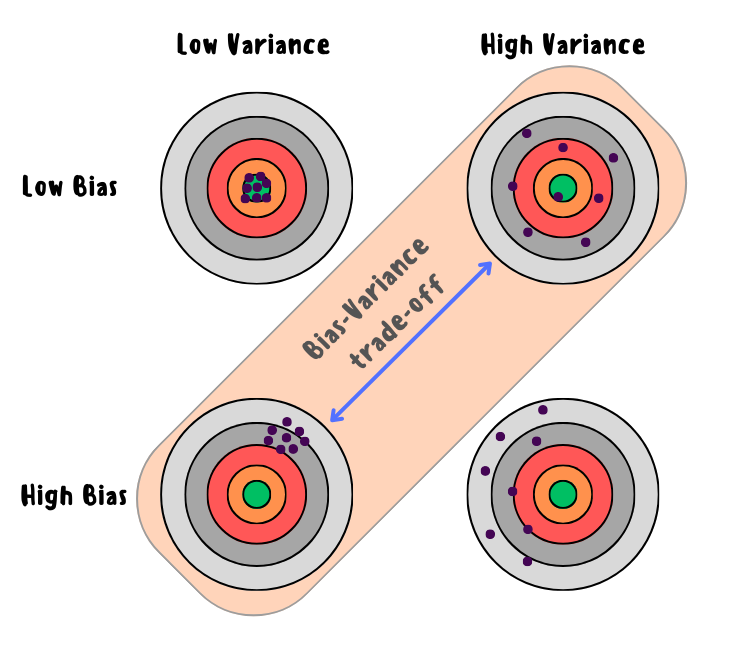

### **Bias-Variance trade-off**

В итоге остаётся два варианта:
- 1) создание простой модели, чтобы она была стабильной и менее чувствительной (низкий разброс), но при этом она может не улавливать все закономерности в данных (высокое смещение);
- 2) создание сложной модели, чтобы она могла улавливать более тонкие закономерности (низкое смещение), однако в таком случае повышается чувствительность к шуму и отдельным точкам в данных (высокий разброс).

Такое явление, как поиск компромисса между смещением и разбросом, в литературе называется **bias-variance trade-off**, из которого следует, что общая ошибка на тестовой выборке имеет вид U-образной кривой.

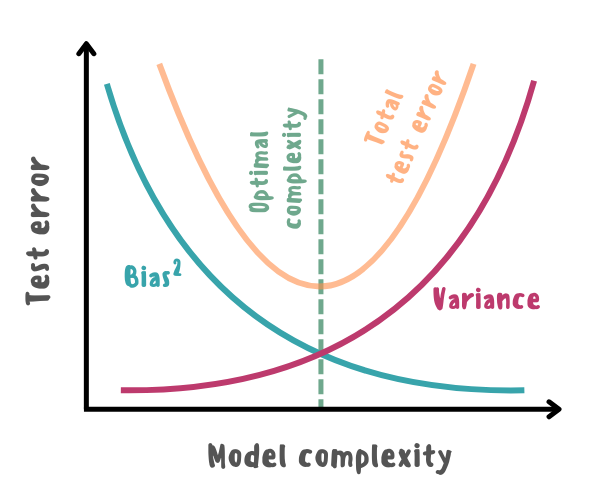

Этот график иллюстрирует, что существует оптимальная сложность модели, при которой ошибка минимальна и при этом также соблюдается баланс между **переобучением** (высокая точность на тренировочных данных и низкая на тестовых) и **недообучением** (неспособность модели улавливать закономерности в тренировочных данных, что приводит к низкой точности как на них, так и на тестовых). Ниже представлен пример для линейной регрессии.

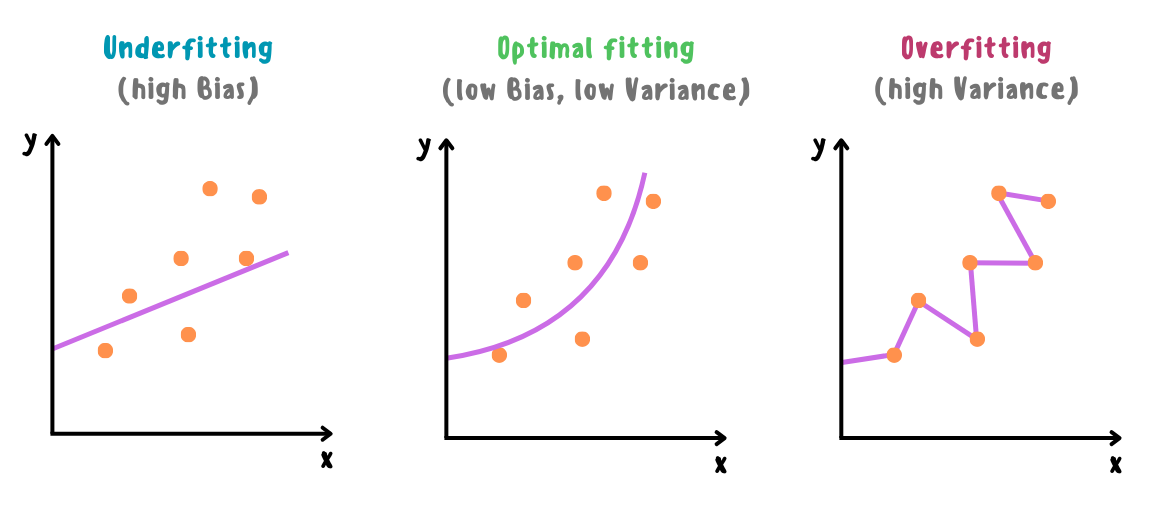

### **Интересные особенности bias-variance**

Стоит отметить два важных момента:

- 1) Полученное разложение ошибки верно только для квадратичной функции потерь. Например, это разложение нельзя применить напрямую к стандартной задаче классификации, поскольку
в таком контексте обычно применяется функция потерь вида 0/1, для которой смещение и разброс уже не являются аддитивными в чистом виде. Поэтому используются более общие формы этого разложения с похожими в некотором смысле компонентами. Так для функции потерь 0/1 смещение может быть определено как 1, если прогноз не совпадает с истинной меткой y, и 0 в противном случае. Разброс, в свою очередь, можно представить как вероятность того, что предсказанная метка не соответствует прогнозу моды. Другими словами, bias-variance decomposition может быть всё ещё применим к большому числу различных функций потерь и алгоритмов, хотя и не в такой простой форме. Более подробно с этим можно ознакомиться в работах Domingos (2000) и Valentini & Dietterich (2004).
-2) Bias-Variance trade-off выполняется при разложении ошибки далеко не в каждом случае. Например, тестовая ошибка глубокой нейронной сети (DNN) часто демонстрирует двойное снижение: по мере увеличения сложности модели она сначала следует классической U-образной кривой, а затем демонстрирует второе снижение. Более того, подобное явление характерно и для ансамблей над решающими деревьями, которое проявляется при одновременном росте глубины и числа деревьев. Проще говоря, с увеличением сложности модели может происходить снижение как смещения, так и разброса. Обычно это вызвано двумя факторами:
 - Bias-variance decomposition в своём классическом представлении недостаточно детализирован
 для выявления всех основных стохастических факторов, объясняющих поведение ошибки в сложных моделях.
 - Постепенное расширение DNN, которое часто приводит к колокообразному разбросу ошибок. Более того, недавно было обнаружено новое явление, известное как **двойной спуск по эпохам** (Nakkiran et al., 2019), возникающее при увеличении количества эпох обучения вместо увеличения сложности модели. В работе Heckel & Yilmaz (2020) показано, что двойной переход по эпохам происходит в ситуации, когда различные части DNN обучаются в разные эпохи, что может быть устранено путём правильного масштабирования размеров шага.

 Обычно решение такой проблемы сводится к использованию более продвинутых методов разложения ошибки, которые включают в себя более информативное разложение разброса, например, симметричное разложение и optimization variance (OV). Поскольку это всё же статья не про нейронные сети, мы опустим реализацию этих концепций с нуля.



## **Метрики кластеризации**

В отличии от классификации, оценка качества кластеризации представляет собой более сложную задачу, поскольку относится к методам обучения без учителя. На то есть несколько причин:

- вместо точного соответствия истинных меток с предсказанными, для нас более важным является группировка похожих объектов внутри одного кластера;
- также зачастую нам неизвестны истинные метки, что делает невозможным их прямое сравнение с полученными результатами.

Метрики кластеризации подразделяются на два типа:
- 1) **Внешние** — основаны на использовании заранее известной информации (например, истинных меток), которая не задействовалась в процессе кластеризации. К ним относятся: Adjusted Rand Index (ARI), Mutual Information, Homogeneity, Completeness, V-measure, Fowlkes-Mallows score.

- 2) **Внутренние** — используют информацию только из структуры обучающего набора. Среди них можно выделить следующие: Silhouette Coefficient, Calinski-Harabasz Index, Davies-Bouldin Index. Такой вариант полезен в случае, когда нет информации об истинных метках (что встречается довольно часто).

Рассмотрим более подробно каждую из этих метрик на сгенерированных данных make blobs.


**Импорт необходимых библиотек**

In [30]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import (rand_score, adjusted_rand_score, mutual_info_score,
                             normalized_mutual_info_score, adjusted_mutual_info_score,
                             homogeneity_score, completeness_score, v_measure_score,
                             homogeneity_completeness_v_measure, fowlkes_mallows_score,
                             silhouette_score, calinski_harabasz_score, davies_bouldin_score)

**Загрузка датасета**

In [31]:
X, y = make_blobs(n_samples=75, n_features=2, centers=5, random_state=0)
print(y)

[0 3 4 3 2 4 0 2 0 4 2 4 2 2 0 0 0 3 2 0 2 2 2 3 4 1 1 2 3 0 4 4 3 3 3 2 2
 0 1 1 3 1 0 2 4 1 4 4 0 4 1 0 3 0 4 1 2 1 4 3 1 1 3 0 3 4 1 2 1 4 0 3 1 1
 3]


**Обучение Affinity Propagation**

In [32]:
ap = AffinityPropagation()
y_pred = ap.fit_predict(X)
print(y_pred)

[2 0 1 2 3 1 2 3 2 1 3 1 3 4 2 2 2 0 3 2 3 3 2 0 1 4 4 3 0 3 1 1 0 0 0 3 3
 2 4 4 0 4 2 3 1 4 1 1 4 1 4 2 0 2 1 4 3 4 1 0 4 4 0 2 0 1 4 3 3 1 2 0 4 4
 0]


**Визуализация полученной кластеризации**

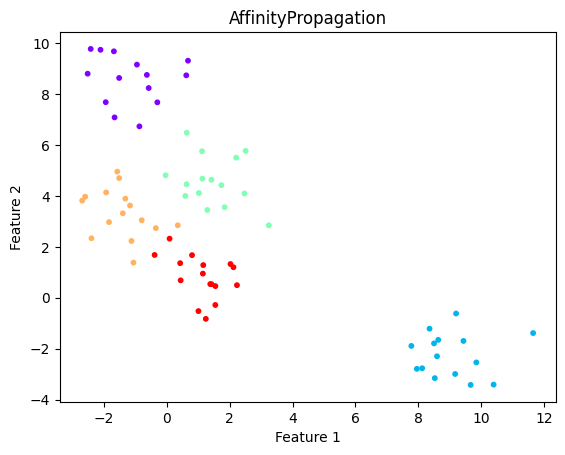

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='rainbow', s=10)
plt.title('AffinityPropagation')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### **Rand Index & Adjusted Rand Index (ARI)**

Являются одними из самых простых метрик. **Rand Index** измеряет количество пар элементов, отнесённых к одинаковым и разным кластерам относительно общего количества возможных пар в данных, игнорируя перестановки:

$$\text{RI} = \frac{a + b}{C_2^{n_{samples}}}$$

Данная метрика хорошо интерпретируема, поскольку её значения расположены в диапазоне [0, 1], где 1 соответствует идеальной кластеризации. С другой стороны, Rand Index не гарантирует, что случайные присвоения меток получат значения, близкие к нулю (особенно если количество кластеров имеет тот же порядок значений, что и количество образцов). Это одна из причин почему Rand Index зачастую даёт слишком оптимистичную оценку.

In [34]:
ri = rand_score(y, y_pred)
print(f'rand index: {ri}')

rand index: 0.9405405405405406


Нормировав данный индекс, можно снизить ожидаемый $E[\text{RI}]$ и таким образом избавиться от негативного эффекта выше. Тогда получим скорректированную оценку, известную как **Adjusted Rand Index (ARI)**:

$$\text{ARI} = \frac{\text{RI} - E[\text{RI}]}{\max(\text{RI}) - E[\text{RI}]}$$

Она симметрична, не зависит от перестановок меток и их значений, которые теперь определены в диапазоне [-1, 1]. В таком случае отрицательное значение будет указывать на то, что кластеризация хуже, чем если бы метки были присвоены случайным образом.

In [35]:
ari = adjusted_rand_score(y, y_pred)
print(f'adjusted rand index: {ari}')

adjusted rand index: 0.8063318846556483


### **Mutual Information & Adjusted Mutual Information (AMI)**

Взаимная информация **Mutual Information** определяет меру различия между совместным распределением пары меток  $U, V$ и произведением их маргинальных распределений. Другими словами, измеряется насколько информация об одной из этих переменных уменьшает неопределенность в отношении другой, то есть между ними определяется мера взаимной зависимости.

В свою очередь, мера неопределённости — это ни что иное, как энотропия, которая определяется для разбиений следующим образом:

$$H(U) = - \sum_{i=1}^{|U|}P(i)\ln(P(i))$$

$$H(V) = - \sum_{j=1}^{|V|}P'(j)\ln(P'(j))$$

где $P(i) = |U_i| / N$ — вероятность попадания случайно выбранного объекта из $U$ в класс $U_i$. В случае с $V$ ситуация аналогична.

Тогда взаимная информация между $U$ и $V$ определяется как:

$$\text{MI}(U, V) = \sum_{i=1}^{|U|}\sum_{j=1}^{|V|}P(i, j)\ln\left(\frac{P(i,j)}{P(i)P'(j)}\right)$$

где $P(i, j) = |U_i \cap V_j| / N$ — вероятность попадания случайно выбранного объекта в оба класса.




In [36]:
mi = mutual_info_score(y, y_pred)
print(f'mutual index: {mi}')

mutual index: 1.3165387166969102


Отсюда также можно получить нормализованную версию, то есть **Normalized Mutual Information (NMI)**:

$$\text{NMI}(U, V) = \frac{\text{MI}(U, V)}{\text{mean}(H(U), H(V))}$$

In [37]:
nmi = normalized_mutual_info_score(y, y_pred)
print(f'normalized mutual index: {nmi}')

normalized mutual index: 0.8182376204426293


Однако обе эти метрики не учитывают случайность разбиений: MI будет склонна к увеличению по мере роста числа кластеров независимо от фактического объёма взаимной информации между метками, а NMI будет давать более оптимистичную оценку в пределах [0, 1].

Для устранения этих недостатков используется **Adjusted Mutual Information (AMI)**, значения которого также расположены в диапазоне [0, 1], где 0 указывает на независимость меток, а значение близкое к 1 на их значительное совпадение:

$$\text{AMI} = \frac{\text{MI} - E[\text{MI}]}{\text{mean}(H(U), H(V)) - E[\text{MI}]}$$

где ожидаемое значение взаимной информации рассчитывается как:

$$E[\text{MI}(U,V)]=\sum_{i=1}^{|U|} \sum_{j=1}^{|V|} \sum_{n_{ij}=(a_i+b_j-N)^+
}^{\min(a_i, b_j)} \frac{n_{ij}}{N}\ln \left( \frac{ N.n_{ij}}{a_i b_j}\right)
\frac{a_i!b_j!(N-a_i)!(N-b_j)!}{N!n_{ij}!(a_i-n_{ij})!(b_j-n_{ij})!
(N-a_i-b_j+n_{ij})!}$$

In [38]:
ami = adjusted_mutual_info_score(y, y_pred)
print(f'adjusted mutual index: {ami}')

adjusted mutual index: 0.8036319585502079


### **Homogeneity, Completeness & V-measure**

Другой, более интуитивно понятный способ применения энтропии заключается в использовании таких понятий как:

- гомогенность — мера того, насколько каждый кластер содержит объекты только одного класса:

$$h = 1 - \frac{H(C|K)}{H(C)} \\
H(C) = - \sum_{c=1}^{|C|} \frac{n_c}{n} \cdot \log\left(\frac{n_c}{n}\right) \\
H(C|K) = - \sum_{c=1}^{|C|} \sum_{k=1}^{|K|} \frac{n_{c,k}}{n}
\cdot \ln\left(\frac{n_{c,k}}{n_k}\right)$$

- полнота — мера того, насколько все объекты одного класса принадлежат одному и тому же кластеру:

$$c = 1 - \frac{H(K|C)}{H(K)}$$

где $C$ — истинные метки классов, а $K$ — спрогнозированные.

В отличие от ARI или AMI, данные метрики не являются нормализованными, поэтому случайная кластеризация не будет давать нулевые показатели при большом числе классов и малом числе объектов. Стоит отметить, что эта проблема не касается ситуаций, когда количество образцов превышает тысячу, а число кластеров меньше 10. В противном же случае лучше использовать ARI.

Если же необходимо учитывать гомогенность и полноту одновременно, то есть обеспечить между ними баланс, то используется **V-мера**, представляющая собой гармоническое среднее между ними и являющаяся в каком-то смысле эквивалентом NMI:

$$v = 2 \cdot \frac{h \cdot c}{h + c}$$



In [39]:
homogeneity = homogeneity_score(y, y_pred)
completeness = completeness_score(y, y_pred)
v_measure = v_measure_score(y, y_pred)

print(f'homogeneity: {homogeneity}')
print(f'completeness: {completeness}')
print(f'v measure: {v_measure}')

homogeneity: 0.8180114973840702
completeness: 0.8184638685502272
v measure: 0.8182376204426292


Следует добавить, что все 3 метрики хорошо интерпретируемые, поскольку лежат в диапазоне [0, 1], где 1 соответствует идеальной кластеризации. Также помимо этого, в scikit-learn имеется возможность получить все три метрики сразу.

In [40]:
hcv = homogeneity_completeness_v_measure(y, y_pred)
print('homogeneity, completeness, v measure:', hcv, sep='\n')

homogeneity, completeness, v measure:
(0.8180114973840702, 0.8184638685502272, 0.8182376204426292)


### **Fowlkes-Mallows Index (FMI)**

Confusion matrix также может быть использована в задачах кластеризации. В таком случае можно получить **Fowlkes-Mallows Index (FMI)**, если взять геометрическое среднее между precision и recall:

$$\text{FMI} = \frac{\text{TP}}{\sqrt{(\text{TP} + \text{FP}) (\text{TP} + \text{FN})}}$$

Эта метрика также лежит в диапазоне [0, 1] и может быть полезна при сравнении различных алгоритмов кластеризации, поскольку не делает никаких предположений об их структуре и, следовательно, может дать более объективную оценку.

In [41]:
fmi = fowlkes_mallows_score(y, y_pred)
print(f'Fowlkes-Mallows index: {fmi}')

Fowlkes-Mallows index: 0.8430070419125244


### **Silhouette Coefficient**

Данный коэффициент показывает насколько в среднем объекты схожи внутри одного кластера и различны с объектами других кластеров. Для одного образца силуэт определяется следующим образом:

$$s = \frac{b - a}{max(a, b)}$$

где:
- $a$ — среднее расстояние между образцом и всеми другими точками в том же классе;

- $b$ — среднее расстояние между образцом и всеми другими точками в следующем ближайшем кластере.

Обычно для выборки силуэт определяется как среднее значение силуэта объектов и лежит в диапазоне [-1, 1], где -1 соответствует неверной кластеризации, 1 указывает на высокую степень соответствия объектов своим кластерам, а 0 говорит о пересекающихся и накладывающихся друг на друга кластерах.

Как можно заметить, данная метрика особенна полезна в случае, когда необходимо подобрать оптимальное количество кластеров, которое выбирается на основе максимального значения силуэта. Однако, следует учитывать, что значение силуэта может быть склонно к завышенным оценкам для выпуклых форм кластера и занижено для сложных форм, особенно для кластеров различного размера и плотности.

In [42]:
silhouette = silhouette_score(X, y_pred)
print(f'silhouette: {silhouette}')

silhouette: 0.5796452132316384


### **Calinski-Harabasz Index (CHI)**

Также известный как критерий соотношения дисперсий (VRC), представляет собой отношение сумм межкластерной и внутрикластерной дисперсий:

$$s = \frac{\mathrm{tr}(B_k)}{\mathrm{tr}(W_k)} \times \frac{n_E - k}{k - 1}$$

где межкластерная $B_k$ и внутрикластерная $W_k$ дисперсии определяются как:

$$B_k = \sum_{q=1}^k n_q (c_q - c_E) (c_q - c_E)^T \\
W_k = \sum_{q=1}^k \sum_{x \in C_q} (x - c_q) (x - c_q)^T$$

а также где:
- $C_q$ — набор точек в кластере $q$;
- $c_q$ — центр кластера $q$;
- $c_E$ — центр в наборе данных $E$;
- $n_q$ — число точек в кластере $q$.


Чем выше значение Калински-Харабаша, тем более чётко модель определяет кластеры. Хотя данная метрика и лучше с вычислительной точки зрения, но, в принципе, имеет такой же недостаток, как и коэффициент силуэта.




In [43]:
chi = calinski_harabasz_score(X, y_pred)
print(f'Calinski-Harabasz index: {chi}')

Calinski-Harabasz index: 305.667448634445


### **Davies-Bouldin Index (DBI)**

Показывает среднее сходство между кластерами, которое определяется как мера, сравнивающая межкластерное расстояние с размером самих кластеров:

$$DB = \frac{1}{k} \sum_{i=1}^k \max_{i \neq j} R_{ij}$$

В данном случае сходство определяется как:

$$R_{ij} = \frac{s_i + s_j}{d_{ij}}$$

где $s$ — среднее расстояние между каждой точкой кластера и его центроидом, а $d_{ij}$ — расстояние между центроидами $i$ и $j$.

В сравнении с метриками выше, более близкое к нулю значение **DBI** говорит о лучшем качестве кластеризации. Хотя данная метрика и обладает тем же недостатком, что и коэффициент силуэта, она может быть более предпочтительным вариантом из-за более простого вычисления.


In [44]:
dbi = davies_bouldin_score(X, y_pred)
print(f'Davies-Bouldin index: {dbi}')

Davies-Bouldin index: 0.546114132526905


## **Дополнительные источники**

Статьи:
- «An introduction to ROC analysis», Tom Fawcett;

- «The Relationship Between Precision-Recall and ROC Curves», Jesse Davis, Mark Goadrich;

- «Precision-Recall-Gain Curves: PR Analysis Done Right», Peter A. Flach, Meelis Kull;

- «Investigation of performance metrics in regression analysis and machine learning-based prediction models», V. Plevris, G. Solorzano, N. Bakas, M. Ben Seghier;

- «A Unified Bias-Variance Decomposition and its Applications», Pedro Domingos;

- «Bias-Variance Analysis of Support Vector Machines for the Development of SVM-Based Ensemble Methods», Giorgio Valentini, Thomas G. Dietterich;

- «Optimization Variance: Exploring Generalization Properties of DNNs», Xiao Zhang, Dongrui Wu, Haoyi Xiong, Bo Dai;

- «Deep Double Descent: Where Bigger Models and More Data Hurt», Preetum Nakkiran, Gal Kaplun, Yamini Bansal, Tristan Yang, Boaz Barak, Ilya Sutskever;

- «Early Stopping in Deep Networks: Double Descent and How to Eliminate it», Reinhard Heckel, Fatih Furkan Yilmaz;

- «Pointwise Metrics for Clustering Evaluation», Stephan van Staden.

Документация:

- [метрики классификации и регрессии](https://scikit-learn.org/stable/modules/model_evaluation.html);

- [метрики кластеризации](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

